In [2]:
!unzip data.zip 

Archive:  data.zip
replace data/beach/beach01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt 
import cv2 
import utils 

%matplotlib inline 

# Clustering 
Using clustering to identify a smaller set of points for prediction.  Turn the regression problem into a classification problem.  

## Data wrangling 

In [5]:
import glob 

filenames = glob.glob('data/beach_with_tree/*.jpg')
filenames

['data/beach_with_tree/tree05.jpg',
 'data/beach_with_tree/tree01.jpg',
 'data/beach_with_tree/tree04.jpg',
 'data/beach_with_tree/tree02.jpg',
 'data/beach_with_tree/tree03.jpg']

`imgs` is a list of all utils.Image objects from the above list 

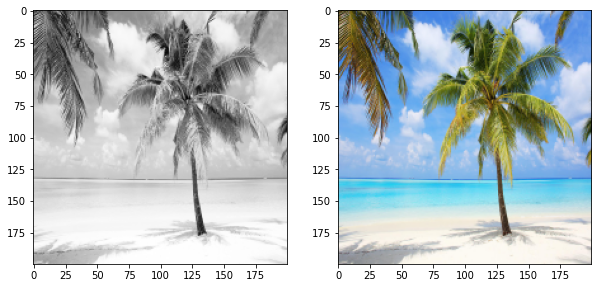

In [6]:
dim = 200
padding = 55

imgs = []

for idx, file in enumerate(filenames): 
    imgs.append(utils.Image(filenames[idx], resize=dim, padding=padding))

    
fig, axes = plt.subplots(1, 2, figsize=(10, 20))
axes[0].imshow(-imgs[0].gray_nopadding, cmap=plt.get_cmap('Greys'))
axes[1].imshow(cv2.cvtColor(imgs[0].data_nopadding, cv2.COLOR_BGR2RGB))

## Identify cluster using kmeans 

In [7]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [55]:
img = imgs[0].data_nopadding/255
n_colors = 32


w, h, d = tuple(img.data.shape)

image_array = np.reshape(img, (w * h, d))
image_array_sample = shuffle(image_array, random_state=0)

kmeans = KMeans(n_clusters=n_colors, random_state = 0, verbose=0).fit(image_array_sample)

In [56]:
clusters  = kmeans.cluster_centers_

clusters = np.array(clusters)

indeces_of_nearest_cluster = kmeans.predict(image_array)
indeces_of_nearest_cluster = np.reshape(indeces_of_nearest_cluster, (w, h))

In [57]:
new_image  = np.zeros(shape = (w,h,d))
for row in range(w):
    for col in range(h):
        new_image[row, col, 0] = clusters[indeces_of_nearest_cluster[row, col], 0]
        new_image[row, col, 1] = clusters[indeces_of_nearest_cluster[row, col], 1]
        new_image[row, col, 2] = clusters[indeces_of_nearest_cluster[row, col], 2]
        
        
new_image = (new_image*255).astype('uint8')

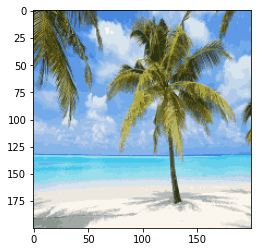

In [58]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

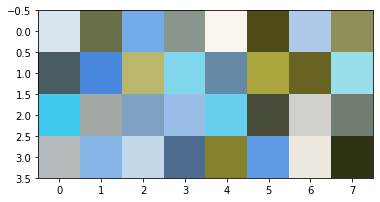

In [59]:
colors = (clusters*255).reshape(4, -1, 3).astype('uint8')
plt.imshow(cv2.cvtColor(colors, cv2.COLOR_BGR2RGB))

## Converting RGB to one-hot encoding 
Do this for all images in `imgs` list 

In [60]:
y = [] 

for img in imgs: 

    img = img.data_nopadding/255

    w, h, d = tuple(img.data.shape)

    image_array = np.reshape(img, (w * h, d))
    
    indeces_of_nearest_cluster = kmeans.predict(image_array)
    indeces_of_nearest_cluster = np.reshape(indeces_of_nearest_cluster, (w, h))
    
    utils.get_onehotencoding_vectors(indeces_of_nearest_cluster, n_colors, y) 
       

y = np.array(y)
w_size = 11 
X, _ = utils.imgs_to_dataset(filenames, resize=dim, padding=padding, window_size=w_size)

In [61]:
X.shape, y.shape

((200000, 121), (200000, 32))

In [62]:
X = utils.normalize(X)

train, test split 

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=2019)

In [64]:
X_train.shape, y_train.shape

((198000, 121), (198000, 32))

## Model building 

In [65]:
from tensorflow.keras.layers import Dense, InputLayer

In [66]:
model = tf.keras.Sequential([ 
    Dense(200, input_shape=(w_size**2, ), activation='sigmoid'), 
    Dense(100, input_shape=(w_size**2, ), activation='sigmoid'), 
    Dense(50, activation='relu'), 
    Dense(n_colors, activation='softmax')
])


In [67]:
opt = tf.keras.optimizers.SGD()
model.compile(optimizer=opt, loss='categorical_crossentropy')  

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 200)               24400     
_________________________________________________________________
dense_17 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_18 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_19 (Dense)             (None, 32)                1632      
Total params: 51,182
Trainable params: 51,182
Non-trainable params: 0
_________________________________________________________________


In [68]:
EPOCHS=50

history = model.fit(X_train, 
                    y_train, 
                    epochs=EPOCHS, 
                    validation_split=0.1, 
                    # callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_exp_decay, verbose=1)],
                    verbose=2)

Epoch 1/50
5569/5569 - 14s - loss: 2.8830 - val_loss: 2.4177
Epoch 2/50
5569/5569 - 13s - loss: 2.1801 - val_loss: 2.0267
Epoch 3/50
5569/5569 - 13s - loss: 1.9167 - val_loss: 1.8288
Epoch 4/50
5569/5569 - 13s - loss: 1.8208 - val_loss: 1.9486
Epoch 5/50
5569/5569 - 13s - loss: 1.7734 - val_loss: 1.6964
Epoch 6/50
5569/5569 - 13s - loss: 1.7400 - val_loss: 1.6752
Epoch 7/50
5569/5569 - 13s - loss: 1.7156 - val_loss: 1.7268
Epoch 8/50
5569/5569 - 13s - loss: 1.6925 - val_loss: 1.6211
Epoch 9/50
5569/5569 - 13s - loss: 1.6760 - val_loss: 1.6026
Epoch 10/50
5569/5569 - 13s - loss: 1.6600 - val_loss: 1.5961
Epoch 11/50
5569/5569 - 13s - loss: 1.6461 - val_loss: 2.5007
Epoch 12/50
5569/5569 - 13s - loss: 1.6351 - val_loss: 1.5878
Epoch 13/50
5569/5569 - 13s - loss: 1.6232 - val_loss: 1.6079
Epoch 14/50
5569/5569 - 13s - loss: 1.6138 - val_loss: 1.5704
Epoch 15/50
5569/5569 - 13s - loss: 1.6068 - val_loss: 1.8253
Epoch 16/50
5569/5569 - 13s - loss: 1.6008 - val_loss: 1.6143
Epoch 17/50
5569/

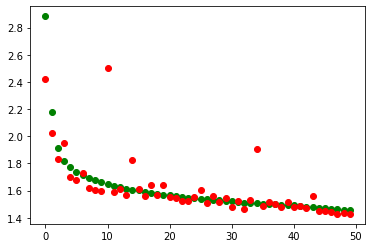

In [69]:
l = history.history['loss']
l_v = history.history['val_loss']


x_ = np.arange(len(l))
plt.scatter(x_, l, c='g') 
plt.scatter(x_, l_v, c='r') 

## Test on image 

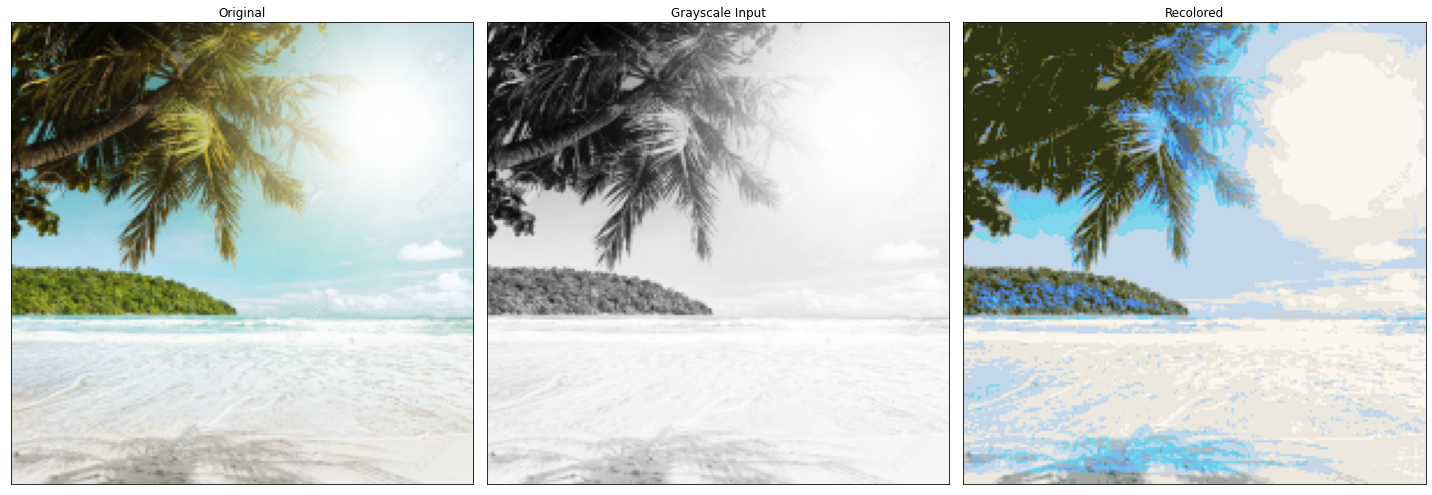

In [76]:
img = imgs[4]
# img = utils.Image('data/cat/cat02.jpg', resize=dim, padding=50) 

X_test = []

for i in range(dim): 
    for j in range(dim): 

        i_ = i + img.padding
        j_ = j + img.padding

        grays, b, g, r = img.get_dataset_for_pixel(i_, j_, window_size=w_size)
        X_test.append(grays)
X_test = np.array(X_test)
X_test = utils.normalize(X_test)
y_model = model.predict(X_test)



new_image  = np.zeros(shape = (y_model.shape[0], 3))

for i in range(y_model.shape[0]):              
    new_image[i] = clusters[np.argmax(y_model[i, :])]
        
new_image = (new_image*255).astype('uint8')
new_image = new_image.reshape(dim, dim, 3)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))

ax[0].imshow(cv2.cvtColor(img.data_nopadding, cv2.COLOR_BGR2RGB))
ax[1].imshow(-img.gray_nopadding, cmap=plt.get_cmap('Greys'))
ax[2].imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

ax[0].set_title('Original')
ax[1].set_title('Grayscale Input')
ax[2].set_title('Recolored')

for a in ax: 
  a.axes.xaxis.set_visible(False)
  a.axes.yaxis.set_visible(False)

plt.tight_layout()